<a href="https://colab.research.google.com/github/C0SS10/AI4ENG-II/blob/main/Breast-Cancer-Wisconsin-Modelado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **📦 Módulos, archivos, paquetes importantes para la ejecución del notebook.**

In [4]:
# Librerias uso básico
import numpy as np
import pandas as pd

# Librerias para gráficar
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Cargamos el dataset

Descargamos el archivo .CSV que está alojado en Google Drive mediante una petición, y luego conseguimos su contenido para ser parseado a texto

In [5]:
import requests
from io import StringIO

# URL con CSV
url = 'https://drive.google.com/uc?export=download&id=1iMiM-j44duS2TrxH4gQL2FStoimnIlT1'

response = requests.get(url)
response.raise_for_status()  # Check if the request was successful
data_csv = StringIO(response.text)

Debido a que el archivo no contiene nombre de columnas, nosotros mismos asignamos los nombres

In [6]:
# Columnas explicadas en https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic > "Additional Variable Information"
# La estructura de las columnas 3 a 32 se presenta en tres formas:
#   - Media (mean)
#   - Error (se)
#   - Peor (worst)

column_names = [
    "ID", "Diagnosis",
    "Radius_mean", "Texture_mean", "Perimeter_mean", "Area_mean", "Smoothness_mean", "Compactness_mean", "Concavity_mean", "Concave_points_mean", "Symmetry_mean", "Fractal_dimension_mean",
    "Radius_se", "Texture_se", "Perimeter_se", "Area_se", "Smoothness_se", "Compactness_se", "Concavity_se", "Concave_points_se", "Symmetry_se", "Fractal_dimension_se",
    "Radius_worst", "Texture_worst", "Perimeter_worst", "Area_worst", "Smoothness_worst", "Compactness_worst", "Concavity_worst", "Concave_points_worst", "Symmetry_worst", "Fractal_dimension_worst"
]

In [7]:
data = pd.read_csv(data_csv, sep = ",", header=None, names=column_names)

In [8]:
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

data.head()

,ID,Diagnosis,Radius_mean,Texture_mean,Perimeter_mean,Area_mean,Smoothness_mean,Compactness_mean,Concavity_mean,Concave_points_mean,...,Radius_worst,Texture_worst,Perimeter_worst,Area_worst,Smoothness_worst,Compactness_worst,Concavity_worst,Concave_points_worst,Symmetry_worst,Fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## PyCaret

Utilizaremos PyCaret para poder conseguir un "ranking" de modelos y ver cuales son mejores para nuestro problema de clasificación

Primero dividiremos el dataset en train y test

In [6]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=123)

Ahora instalamos PyCaret

In [7]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.

Realizamos el setup de PyCaret

In [8]:
clf = setup(data=train_data, target='Diagnosis', session_id=123)

NameError: name 'setup' is not defined

In [ ]:
best_model = compare_models()

In [ ]:
tuned_model = tune_model(best_model)

In [ ]:
evaluate_model(tuned_model)

In [ ]:
final_model = finalize_model(tuned_model)

In [ ]:
predictions = predict_model(best_model, data=test_data)

## **Analisis y Resultados** 📊

In [9]:
# X = data[['Radius_mean', 'Texture_mean', 'Perimeter_mean', 'Area_mean', 'Smoothness_mean',
#          'Compactness_mean', 'Concavity_mean', 'Concave_points_mean', 'Symmetry_mean',
#          'Fractal_dimension_mean']]
X = data.iloc[:, 2:]
y = data['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### **Regresion Logistica** 📈

In [10]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [11]:
# Predecir las etiquetas para el conjunto de datos de entrenamiento
y_pred = model.predict(X_train)

# Calcular métricas de evaluación
accuracy_lr = accuracy_score(y_train, y_pred)
precision_lr = precision_score(y_train, y_pred)
recall_lr = recall_score(y_train, y_pred)
f1_lr = f1_score(y_train, y_pred)
roc_auc_lr = roc_auc_score(y_train, y_pred)
conf_matrix_lr = confusion_matrix(y_train, y_pred)

# Calcular la matriz de confusión para el entrenamiento
conf_matrix_train = confusion_matrix(y_train, y_pred)

print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)
print("Roc Auc Score:", roc_auc_lr)
print("Confusion Matrix:\n", conf_matrix_lr)
print("Confusion Matrix para el conjunto de entrenamiento:\n", conf_matrix_train)


Accuracy: 0.9648351648351648
Precision: 0.963855421686747
Recall: 0.9411764705882353
F1 Score: 0.9523809523809523
Roc Auc Score: 0.9600619195046439
Confusion Matrix:
 [[279   6]
 [ 10 160]]
Confusion Matrix para el conjunto de entrenamiento:
 [[279   6]
 [ 10 160]]


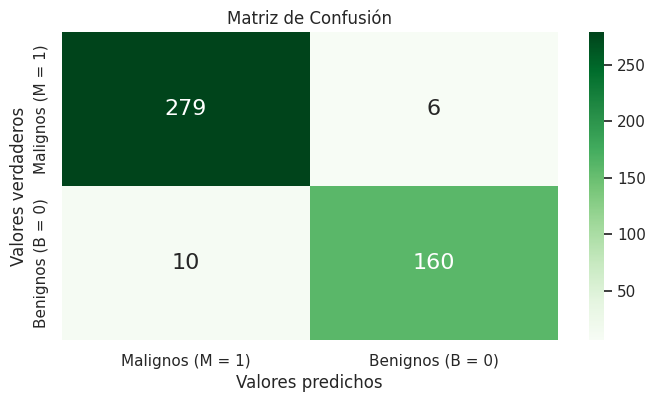

In [12]:
# Crear la figura y el eje
plt.figure(figsize=(8, 4))
sns.set(font_scale=1)


# Crear el heatmap
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Greens", annot_kws={"size": 16},
            xticklabels=['Malignos (M = 1)', 'Benignos (B = 0)'],
            yticklabels=['Malignos (M = 1)', 'Benignos (B = 0)'])


# Añadir etiquetas y título
plt.ylabel('Valores verdaderos')
plt.xlabel('Valores predichos')
plt.title('Matriz de Confusión')

# Mostrar el plot
plt.show()

### **🏠 KNN | K vecinos más próximos 🏠**

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Text(0.5, 1.0, 'Elbow for KMeans clustering')

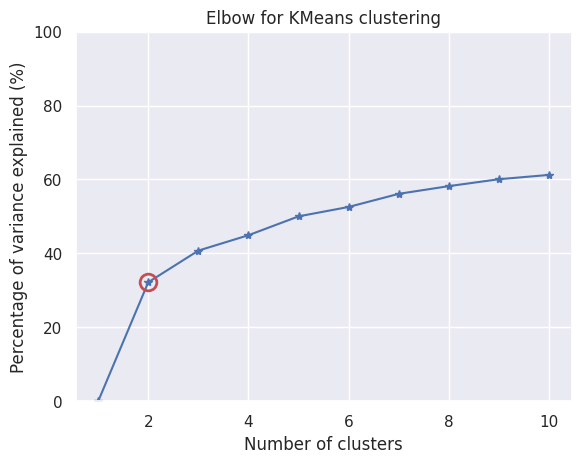

In [14]:
import numpy as np
from scipy.cluster.vq import kmeans
from scipy.spatial.distance import cdist,pdist
from sklearn import datasets
from matplotlib import pyplot as plt
from matplotlib import cm

##### cluster data into K=1..20 clusters #####
K_MAX = 10
KK = range(1,K_MAX+1)

X = X_train

KM = [kmeans(X,k) for k in KK]
centroids = [cent for (cent,var) in KM]
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]

tot_withinss = [sum(d**2) for d in dist]  # Total within-cluster sum of squares
totss = sum(pdist(X)**2)/X.shape[0]       # The total sum of squares
betweenss = totss - tot_withinss          # The between-cluster sum of squares

##### plots #####
kIdx = 1        # K=10
mrk = 'os^p<dvh8>+x.'

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(KK, betweenss/totss*100, 'b*-')
ax.plot(KK[kIdx], betweenss[kIdx]/totss*100, marker='o', markersize=12,
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained (%)')
plt.title('Elbow for KMeans clustering')

In [15]:
# Crear una instancia del modelo KNN, con K = 2
knn = KNeighborsClassifier(n_neighbors=2)

# Entrenar el modelo
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [16]:
# Predecir las etiquetas para el conjunto de datos de prueba
y_pred = knn.predict(X_train)

# Calcular métricas de evaluación
accuracy_knn = accuracy_score(y_train, y_pred)
precision_knn = precision_score(y_train, y_pred)
recall_knn = recall_score(y_train, y_pred)
f1_knn = f1_score(y_train, y_pred)
roc_auc_knn = roc_auc_score(y_train, y_pred)
conf_matrix_knn = confusion_matrix(y_train, y_pred)

# Predecir las etiquetas para el conjunto de datos de entrenamiento
# y_train_pred = knn.predict(X_train)

# Calcular la matriz de confusión para el conjunto de entrenamiento
conf_matrix_train = confusion_matrix(y_train, y_pred)

print("Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print("F1 Score:", f1_knn)
print("Roc Auc Score:", roc_auc_knn)
print("Confusion Matrix:\n", conf_matrix_knn)
print("Confusion Matrix para el conjunto de entrenamiento:\n", conf_matrix_train)

Accuracy: 0.9736263736263736
Precision: 1.0
Recall: 0.9294117647058824
F1 Score: 0.9634146341463414
Roc Auc Score: 0.9647058823529412
Confusion Matrix:
 [[285   0]
 [ 12 158]]
Confusion Matrix para el conjunto de entrenamiento:
 [[285   0]
 [ 12 158]]


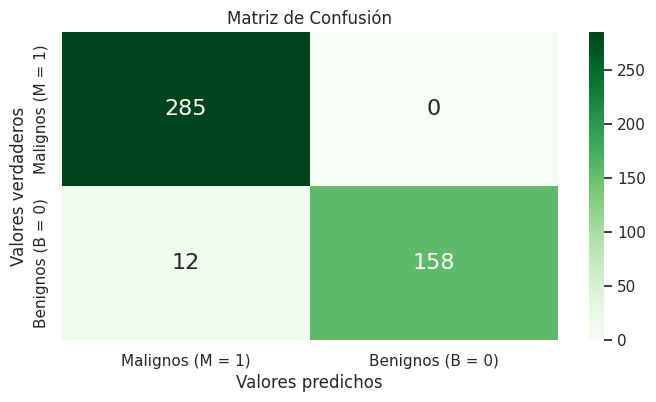

In [17]:
# Crear la figura y el eje
plt.figure(figsize=(8, 4))
sns.set(font_scale=1)


# Crear el heatmap
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Greens", annot_kws={"size": 16},
            xticklabels=['Malignos (M = 1)', 'Benignos (B = 0)'],
            yticklabels=['Malignos (M = 1)', 'Benignos (B = 0)'])


# Añadir etiquetas y título
plt.ylabel('Valores verdaderos')
plt.xlabel('Valores predichos')
plt.title('Matriz de Confusión')

# Mostrar el plot
plt.show()

### **Arboles de Decision** 🌳

In [41]:
from sklearn.model_selection import GridSearchCV

# Rangos de hiperparámetros
param_grid = {
    'max_depth': [2, 4, 6, 8, 10, None],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'min_samples_split': [2, 4, 8, 16, 32]
}

# Definir las métricas como scorings personalizados
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'accuracy': make_scorer(accuracy_score)
}

# Crear una instancia de GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring=scoring,
                           cv=3,  # Validación cruzada de 3 iteraciones
                           refit='roc_auc',  # Métrica utilizada para seleccionar el mejor modelo
                           n_jobs=-1)

# Ajustar la cuadrícula de búsqueda a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los hiperparámetros óptimos
best_params = grid_search.best_params_

# Obtener el mejor estimador
best_estimator = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_estimator.predict(X_test)
metrics = grid_search.cv_results_['mean_test_precision'][grid_search.best_index_]
precision = grid_search.cv_results_['mean_test_recall'][grid_search.best_index_]
recall = grid_search.cv_results_['mean_test_f1'][grid_search.best_index_]
f1 = grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_]
roc_auc = grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Hiperparámetros óptimos:", best_params)
print("Precisión:", precision)
print("Recuperación:", recall)
print("Puntaje F1:", f1)
print("ROC AUC:", roc_auc)
print("Accuracy:", accuracy)

Hiperparámetros óptimos: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Precisión: 0.9235588972431078
Recuperación: 0.9178415296856076
Puntaje F1: 0.9354636591478697
ROC AUC: 0.9384367375392122
Accuracy: 0.9298245614035088


Utilizando los hiperparametros proporcionados por GridSearch 🤓

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# Crear una instancia del modelo de Árbol de Decisión
tree = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_leaf=1, min_samples_split=2)

# Entrenar el modelo
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [51]:
y_pred_test = tree.predict(X_test)

accuracy_dt_test = accuracy_score(y_test, y_pred_test)
precision_dt_test = precision_score(y_test, y_pred_test)
recall_dt_test = recall_score(y_test, y_pred_test)
f1_dt_test = f1_score(y_test, y_pred_test)
roc_auc_dt_test = roc_auc_score(y_test, y_pred_test)

Las métricas de evaluación para el conjunto de prueba `X_test` 📊

In [52]:
y_pred_train = tree.predict(X_train)

accuracy_dt_train = accuracy_score(y_train, y_pred_train)
precision_dt_train = precision_score(y_train, y_pred_train)
recall_dt_train = recall_score(y_train, y_pred_train)
f1_dt_train = f1_score(y_train, y_pred_train)
roc_auc_dt_train = roc_auc_score(y_train, y_pred_train)

Las métricas de evaluación para el conjunto de entrenamiento `X_train` 📊

In [53]:
metricas_dt = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Conjunto de Entrenamiento': [accuracy_dt_train, precision_dt_train, recall_dt_train, f1_dt_train, roc_auc_dt_train],
    'Conjunto de Prueba': [accuracy_dt_test, precision_dt_test, recall_dt_test, f1_dt_test, roc_auc_dt_test]
})

metricas_dt = metricas_dt.set_index('Métrica')

metricas_dt

,Conjunto de Entrenamiento,Conjunto de Prueba
Métrica,,
Accuracy,1.0,0.929825
Precision,1.0,0.904762
Recall,1.0,0.904762
F1 Score,1.0,0.904762
ROC AUC,1.0,0.924603


- **Exactitud (Accuracy)** 🎯: El modelo tiene un mejor rendimiento al predecir los datos en los que fue entrenado que en datos nuevos.
- **Precisión** 🎯: El modelo tiene una buena capacidad para predecir verdaderos positivos
- **Recall**: El modelo es mejor cuando se predicen los verdaderos positivos con los datos que fue entrenado que con datos nuevos.
- **F1 Score** 🎯: Hay equilibrio entre precisión y recall en los datos de entrenamiento.
- **AUC**: Mejor rendimiento en la clasificación de datos de entrenamiento.

In [54]:
conf_matrix_dt_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_dt_test = confusion_matrix(y_test, y_pred_test)

conf_matrix_dt_train, conf_matrix_dt_test

(array([[285,   0],
        [  0, 170]]),
 array([[68,  4],
        [ 4, 38]]))

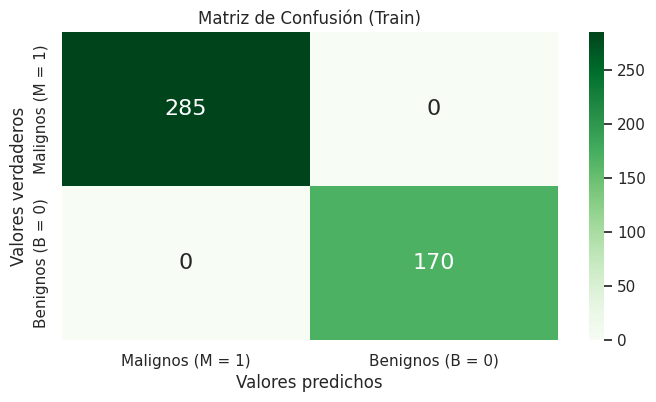

In [55]:
# Crear la figura y el eje
plt.figure(figsize=(8, 4))
sns.set(font_scale=1)


# Crear el heatmap
sns.heatmap(conf_matrix_dt_train, annot=True, fmt="d", cmap="Greens", annot_kws={"size": 16},
            xticklabels=['Malignos (M = 1)', 'Benignos (B = 0)'],
            yticklabels=['Malignos (M = 1)', 'Benignos (B = 0)'])


# Añadir etiquetas y título
plt.ylabel('Valores verdaderos')
plt.xlabel('Valores predichos')
plt.title('Matriz de Confusión (Train)')

# Mostrar el plot
plt.show()

Se ve como el modelo en el conjunto de entrenamiento funciona **PERFECTAMENTE**, con un número significativamente menor de errores. 📊

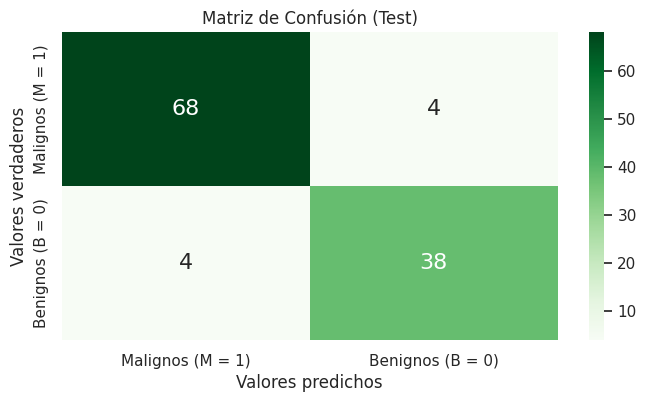

In [56]:
# Crear la figura y el eje
plt.figure(figsize=(8, 4))
sns.set(font_scale=1)


# Crear el heatmap
sns.heatmap(conf_matrix_dt_test, annot=True, fmt="d", cmap="Greens", annot_kws={"size": 16},
            xticklabels=['Malignos (M = 1)', 'Benignos (B = 0)'],
            yticklabels=['Malignos (M = 1)', 'Benignos (B = 0)'])


# Añadir etiquetas y título
plt.ylabel('Valores verdaderos')
plt.xlabel('Valores predichos')
plt.title('Matriz de Confusión (Test)')

# Mostrar el plot
plt.show()

Aunque el modelo aún tiene un rendimiento **PERFECTO** en el conjunto de pruebas, se observa un ligero aumento en el número de errores en comparación con el conjunto de entrenamiento. 📊

In [61]:
print(data['Diagnosis'])
print(data['Diagnosis'].unique())

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: Diagnosis, Length: 569, dtype: int64
[1 0]


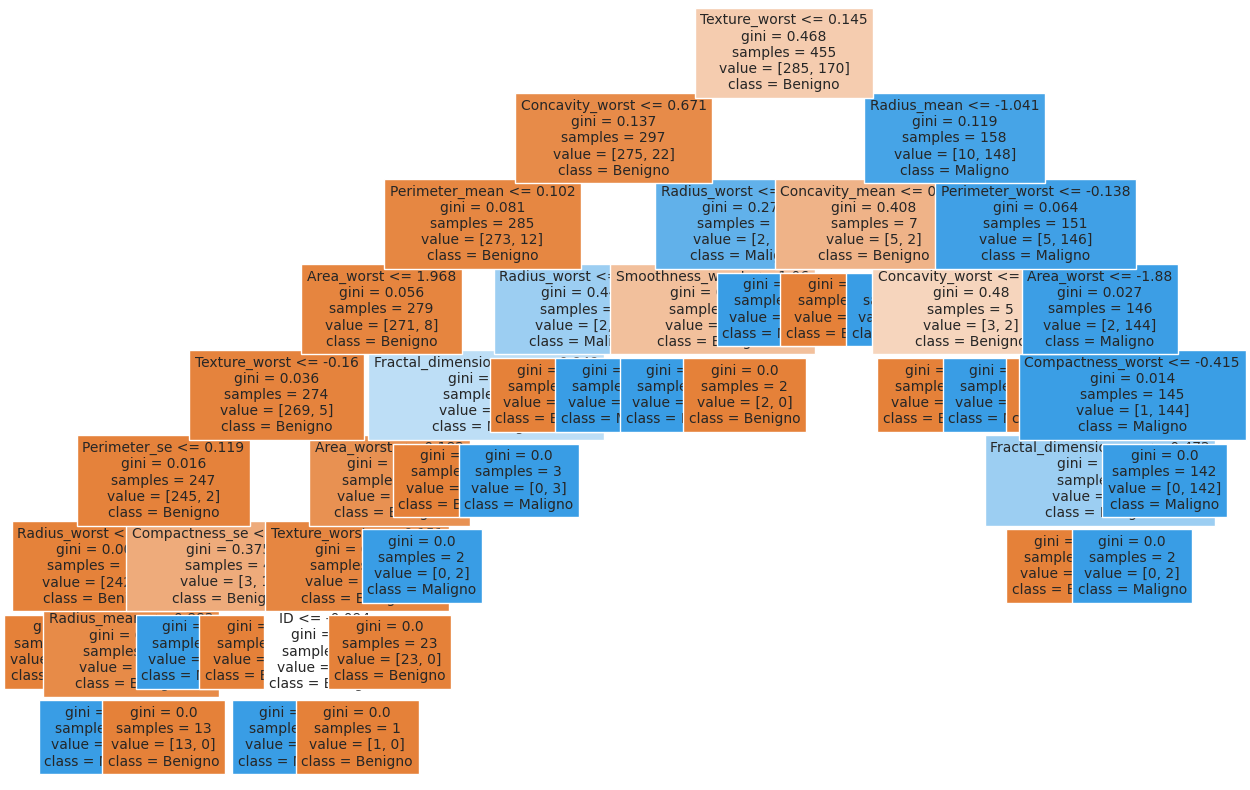

In [66]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Nombres de características (features)
feature_names = data.columns.tolist()
feature_names.remove('Diagnosis')

# Nombres de clases
class_names = ['Benigno', 'Maligno']

# Visualizar el árbol de decisión entrenado
plt.figure(figsize=(15, 10))
plot_tree(tree, filled=True, feature_names=feature_names, class_names=class_names, fontsize=10, max_depth=8)
plt.show()

### Comparación entre resultados

In [ ]:
results = {
    'Model': ['Logistic Regression', 'KNN', 'Decision Tree'],
    'Accuracy': [accuracy_lr, accuracy_knn, accuracy_dt],
    'Precision': [precision_lr, precision_knn, precision_dt],
    'Recall': [recall_lr, recall_knn, recall_dt],
    'F1 Score': [f1_lr, f1_knn, f1_dt],
    'ROC AUC': [roc_auc_lr, roc_auc_knn, roc_auc_dt]
}

results_df = pd.DataFrame(results)
results_df